## LSTM

### [multivariate-time-series](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)

In [2]:
import numpy
from numpy import concatenate
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


Using TensorFlow backend.


In [4]:
dataframe = pandas.read_csv('minite_stock_price.csv', engine='python')
dataframe

,time,open price,highest price,lowest price,close price,turnover,volume,mean price
0,2015-07-17 9:31,23.98,24.04,23.79,23.81,35.06,1464500,23.90
1,2015-07-17 9:32,23.82,23.90,23.79,23.90,13.43,563900,23.86
2,2015-07-17 9:33,23.90,23.96,23.89,23.90,10.92,457000,23.90
3,2015-07-17 9:34,23.96,23.96,23.78,23.79,15.15,636300,23.88
4,2015-07-17 9:35,23.78,23.80,23.78,23.79,10.30,432900,23.79
5,2015-07-17 9:36,23.80,23.80,23.77,23.77,53.14,2235384,23.79
6,2015-07-17 9:37,23.78,23.78,23.56,23.60,15.65,660016,23.69
7,2015-07-17 9:38,23.55,23.60,23.51,23.60,20.63,876500,23.58
8,2015-07-17 9:39,23.58,23.70,23.58,23.69,8.50,359209,23.64
9,2015-07-17 9:40,23.70,23.71,23.68,23.68,9.11,384300,23.69


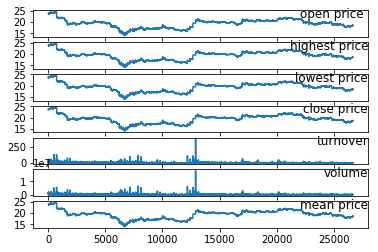

In [5]:
values = dataframe.values
# specify columns to plot
groups = [1, 2, 3, 4, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataframe.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [137]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pandas.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pandas.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [138]:
# load dataset
groups = [1, 2, 3, 4, 5, 6, 7]
values = dataframe.values[:, groups]
# print values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# print scaled
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[8, 9,10, 11, 12, 13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.811321   0.822103   0.774536   0.764075   0.272508   0.265179   
2   0.768194   0.784366   0.774536   0.788203   0.104338   0.102051   
3   0.789757   0.800539   0.801061   0.788203   0.084824   0.082687   
4   0.805930   0.800539   0.771883   0.758713   0.117711   0.115165   
5   0.757413   0.757412   0.771883   0.758713   0.080003   0.078322   

   var7(t-1)   var1(t)  
1   0.793478  0.768194  
2   0.782609  0.789757  
3   0.793478  0.805930  
4   0.788043  0.757413  
5   0.763587  0.762803  


In [139]:
# split into train and test sets
values = reframed.values
# print values
n_train_hours = 6 * 60
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

((360, 1, 7), (360,), (1079, 1, 7), (1079,))


In [140]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [141]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 360 samples, validate on 1079 samples
Epoch 1/50
 - 1s - loss: 0.8277 - val_loss: 0.4232
Epoch 2/50
 - 0s - loss: 0.7544 - val_loss: 0.3760
Epoch 3/50
 - 0s - loss: 0.6810 - val_loss: 0.3283
Epoch 4/50
 - 0s - loss: 0.6066 - val_loss: 0.2798
Epoch 5/50
 - 0s - loss: 0.5299 - val_loss: 0.2297
Epoch 6/50
 - 0s - loss: 0.4496 - val_loss: 0.1778
Epoch 7/50
 - 0s - loss: 0.3643 - val_loss: 0.1309
Epoch 8/50
 - 0s - loss: 0.2729 - val_loss: 0.1061
Epoch 9/50
 - 0s - loss: 0.1741 - val_loss: 0.0992
Epoch 10/50
 - 0s - loss: 0.0682 - val_loss: 0.0945
Epoch 11/50
 - 0s - loss: 0.0315 - val_loss: 0.1168
Epoch 12/50
 - 0s - loss: 0.0509 - val_loss: 0.1032
Epoch 13/50
 - 0s - loss: 0.0234 - val_loss: 0.0949
Epoch 14/50
 - 0s - loss: 0.0268 - val_loss: 0.0949
Epoch 15/50
 - 0s - loss: 0.0173 - val_loss: 0.0955
Epoch 16/50
 - 0s - loss: 0.0182 - val_loss: 0.0954
Epoch 17/50
 - 0s - loss: 0.0167 - val_loss: 0.0938
Epoch 18/50
 - 0s - loss: 0.0160 - val_loss: 0.0935
Epoch 19/50
 - 0s - loss: 

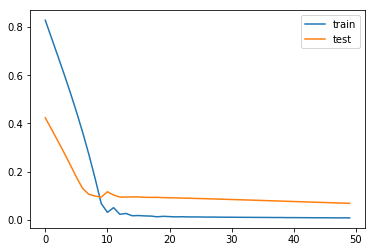

In [143]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [144]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = numpy.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = numpy.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.307
